In [1]:
%matplotlib inline


# Pulsar analysis

Produce a phasogram, phased-resolved maps and spectra for pulsar analysis.

## Introduction



This notebook shows how to do a pulsar analysis with Gammapy. It’s based
on a Vela simulation file from the CTA DC1, which already contains a
column of phases. We will produce a phasogram, a phase-resolved map and
a phase-resolved spectrum of the Vela pulsar using the class
PhaseBackgroundEstimator.

The phasing in itself is not done here, and it requires specific
packages like Tempo2 or [PINT](https://nanograv-pint.readthedocs.io). A Gammapy recipe is available here (put link) to show how to compute phases with PINT in the framework of Gammapy.


## Opening the data




Let’s first do the imports and load the only observation containing Vela
in the CTA 1DC dataset shipped with Gammapy.




In [2]:
import gammapy
print(gammapy.__version__)

1.1.dev502+g5bc72905f


In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

# %matplotlib inline
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDataset, MapDataset
from gammapy.estimators import FluxPointsEstimator, ExcessMapEstimator, TSMapEstimator
from gammapy.makers import PhaseBackgroundMaker, SafeMaskMaker, SpectrumDatasetMaker, MapDatasetMaker
from gammapy.maps import Map, MapAxis, RegionGeom, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import PowerLawSpectralModel, SkyModel

## Check setup



In [4]:
from gammapy.utils.check import check_tutorials_setup
from gammapy.utils.regions import SphericalCircleSkyRegion

check_tutorials_setup()


System:

	python_executable      : /Users/mregeard/anaconda3/envs/gammapy-dev/bin/python 
	python_version         : 3.8.15     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 1.1.dev502+g5bc72905f 
	path                   : /Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy 


Other packages:

	numpy                  : 1.22.4     
	scipy                  : 1.9.3      
	astropy                : 5.2.1      
	regions                : 0.7        
	click                  : 8.1.3      
	yaml                   : 6.0        
	IPython                : 8.9.0      
	jupyterlab             : 3.5.3      
	matplotlib             : 3.6.3      
	pandas                 : 1.5.3      
	healpy                 : 1.16.2     
	iminuit                : 2.18.0     
	sherpa                 : 4.15.0     
	naima                  : 0.10.0     
	emcee                  : 3.1.4      
	corner                 : 2.2.1      


Gammapy env

Load the data store (which is a subset of CTA-DC1 data):




In [5]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps")

Define obsevation ID and print events:




In [6]:
id_obs_vela = [111630]
obs_list_vela = data_store.get_observations(id_obs_vela)
print(obs_list_vela[0].events)

EventList
---------

  Instrument       : None
  Telescope        : CTA
  Obs. ID          : 111630

  Number of events : 101430
  Event rate       : 56.350 1 / s

  Time start       : 59300.833333333336
  Time stop        : 59300.854166666664

  Min. energy      : 3.00e-02 TeV
  Max. energy      : 1.52e+02 TeV
  Median energy    : 1.00e-01 TeV

  Max. offset      : 5.0 deg



Now that we have our observation, let’s select the events in 0.2° radius
around the pulsar position.




In [7]:
pos_target = SkyCoord(ra=128.836 * u.deg, dec=-45.176 * u.deg, frame="icrs")
on_radius = 0.2 * u.deg
on_region = SphericalCircleSkyRegion(pos_target, on_radius)

# Apply angular selection
events_vela = obs_list_vela[0].events.select_region(on_region)
print(events_vela)

EventList
---------

  Instrument       : None
  Telescope        : CTA
  Obs. ID          : 111630

  Number of events : 843
  Event rate       : 0.468 1 / s

  Time start       : 59300.833333333336
  Time stop        : 59300.854166666664

  Min. energy      : 3.00e-02 TeV
  Max. energy      : 4.33e+01 TeV
  Median energy    : 1.07e-01 TeV

  Max. offset      : 1.7 deg



Let’s load the phases of the selected events in a dedicated array.




In [8]:
phases = events_vela.table["PHASE"]

# Let's take a look at the first 10 phases
display(phases[:10])

0.81847286
0.45646095
0.111507416
0.43416595
0.76837444
0.3639946
0.58693695
0.51095676
0.5606985
0.2505703


## Phasogram

Once we have the phases, we can make a phasogram. A phasogram is a
histogram of phases and it works exactly like any other histogram (you
can set the binning, evaluate the errors based on the counts in each
bin, etc).




Text(0.5, 1.0, 'Phasogram with angular cut of 0.2 deg')

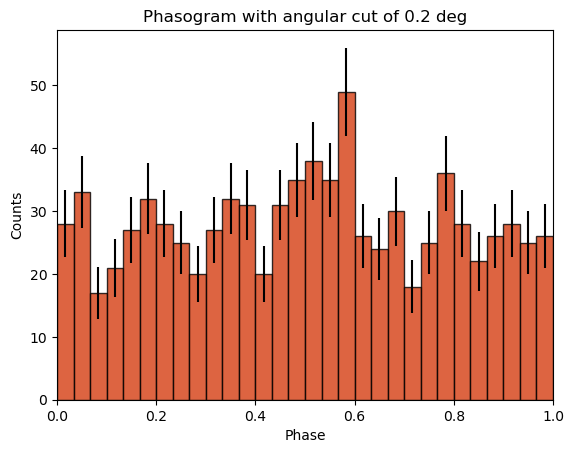

In [9]:
nbins = 30
phase_min, phase_max = (0, 1)
values, bin_edges = np.histogram(phases, range=(phase_min, phase_max), bins=nbins)
bin_width = (phase_max - phase_min) / nbins

bin_center = (bin_edges[:-1] + bin_edges[1:]) / 2


# Poissonian uncertainty on each bin
values_err = np.sqrt(values)

fig, ax = plt.subplots()
ax.bar(
    x=bin_center,
    height=values,
    width=bin_width,
    color="#d53d12",
    alpha=0.8,
    edgecolor="black",
    yerr=values_err,
)
ax.set_xlim(0, 1)
ax.set_xlabel("Phase")
ax.set_ylabel("Counts")
ax.set_title(f"Phasogram with angular cut of {on_radius}")

Now let’s add some fancy additions to our phasogram: a patch on the ON-
and OFF-phase regions and one for the background level.




Number of Off events: 234


Text(0.5, 1.0, 'Phasogram with angular cut of 0.2 deg')

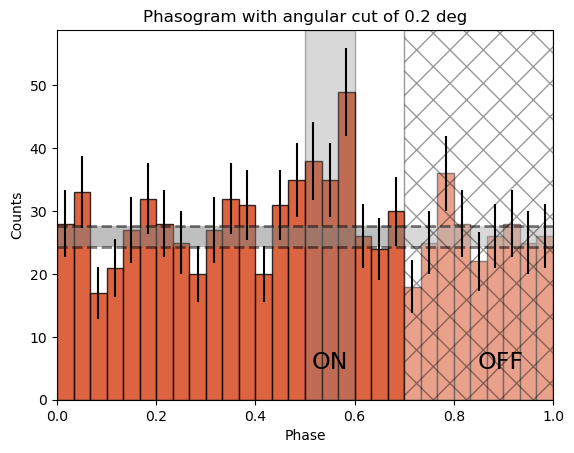

In [10]:
# Evaluate background level
off_phase_range = (0.7, 1.0)
on_phase_range = (0.5, 0.6)

mask_off = (off_phase_range[0] < phases) & (phases < off_phase_range[1])

count_bkg = mask_off.sum()
print(f"Number of Off events: {count_bkg}")

# bkg level normalized by the size of the OFF zone (0.3)
bkg = count_bkg / nbins / (off_phase_range[1] - off_phase_range[0])

# error on the background estimation
bkg_err = np.sqrt(count_bkg) / nbins / (off_phase_range[1] - off_phase_range[0])

# Let's redo the same plot for the basis
fig, ax = plt.subplots()
ax.bar(
    x=bin_center,
    height=values,
    width=bin_width,
    color="#d53d12",
    alpha=0.8,
    edgecolor="black",
    yerr=values_err,
)

# Plot background level
x_bkg = np.linspace(0, 1, 50)

kwargs = {"color": "black", "alpha": 0.5, "ls": "--", "lw": 2}

ax.plot(x_bkg, (bkg - bkg_err) * np.ones_like(x_bkg), **kwargs)
ax.plot(x_bkg, (bkg + bkg_err) * np.ones_like(x_bkg), **kwargs)

ax.fill_between(
    x_bkg, bkg - bkg_err, bkg + bkg_err, facecolor="grey", alpha=0.5
)  # grey area for the background level

# Let's make patches for the on and off phase zones
on_patch = ax.axvspan(
    on_phase_range[0], on_phase_range[1], alpha=0.3, color="gray", ec="black"
)

off_patch = ax.axvspan(
    off_phase_range[0],
    off_phase_range[1],
    alpha=0.4,
    color="white",
    hatch="x",
    ec="black",
)

# Legends "ON" and "OFF"
ax.text(0.55, 5, "ON", color="black", fontsize=17, ha="center")
ax.text(0.895, 5, "OFF", color="black", fontsize=17, ha="center")
ax.set_xlabel("Phase")
ax.set_ylabel("Counts")
ax.set_xlim(0, 1)
ax.set_title(f"Phasogram with angular cut of {on_radius}")

## Phase-resolved map




Now that we have an overview of the phasogram of the pulsar, we can do a phase-resolved sky map
: a map of the ON-phase events minus alpha times the OFF-phase events.
Alpha is the ratio between the size of the ON-phase zone (here 0.1) and
the OFF-phase zone (0.3). It’s a map of the excess events in phase,
which are the pulsed events.




In [11]:
e_true = MapAxis.from_energy_bounds(0.003, 10, 6, per_decade=True, unit="TeV", name="energy_true")
e_reco = MapAxis.from_energy_bounds(0.01, 10, 4, per_decade=True, unit="TeV", name="energy")

geom = WcsGeom.create(binsz=0.02 * u.deg, skydir=pos_target, width="5 deg", axes=[e_reco])

Let’s create an ON-map and an OFF-map:




In [12]:
map_dataset_empty = MapDataset.create(geom=geom, energy_axis_true=e_true)

map_dataset_maker = MapDatasetMaker()
phase_bkg_maker = PhaseBackgroundMaker(
    on_phase=on_phase_range, off_phase=off_phase_range, phase_column_name='PHASE'
)
safe_mask_maker = SafeMaskMaker(methods=["edisp-bias"], bias_percent=10)

map_datasets = Datasets()

for obs in obs_list_vela:
    map_dataset = map_dataset_maker.run(map_dataset_empty, obs)
    map_dataset_on_off = phase_bkg_maker.run(map_dataset, obs)
    map_dataset_on_off = safe_mask_maker.run(map_dataset_on_off, obs)
    map_datasets.append(map_dataset_on_off)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


Once the data reduction is done, we can plot the map of the counts-ON (i.e. in the ON-phase) and the map of the background (i.e. the counts-OFF, selected in the OFF-phase, multiplied by alpha). If one wants to plot the counts-OFF instead, `background`should be replaced by `counts_off`in the following cell. 

<WCSAxesSubplot: >

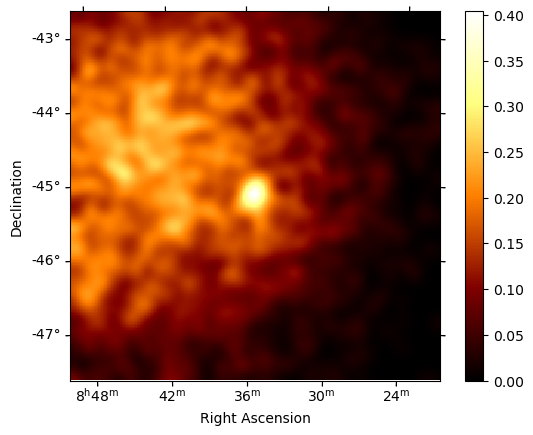

In [35]:
map_datasets[0].counts.smooth(kernel="gauss", width=0.1 * u.deg).sum_over_axes().plot(add_cbar=True)

<WCSAxesSubplot: >

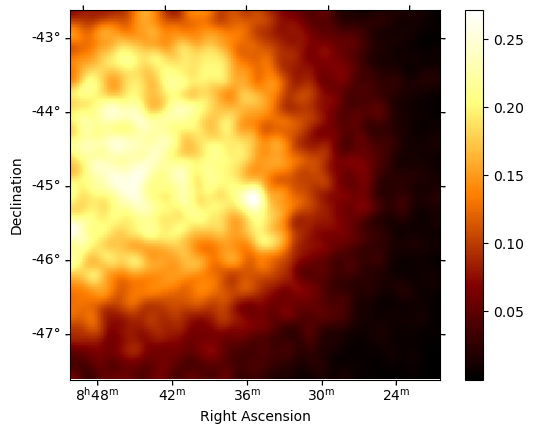

In [36]:
map_datasets[0].background.smooth(kernel="gauss", width=0.1 * u.deg).sum_over_axes().plot(add_cbar=True)

We can also plot the excess map, which is the map of the counts minus the map of the background. Here we show how this can be done by summing over all energy bins. But this can also be done in each energy bins by not calling `sum_over_axes()`and calling `plot_grid()`instead of `plot()`in the following cell.

In [13]:
excess_map = map_datasets[0].excess

<WCSAxesSubplot: >

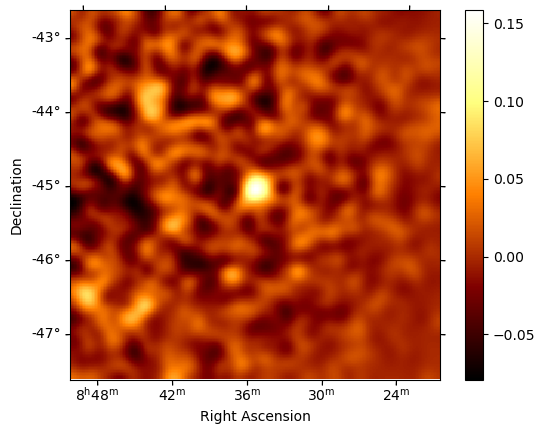

In [37]:
excess_map.sum_over_axes(axes_names=["energy"]).smooth(kernel="gauss", width=0.1 * u.deg).plot(add_cbar=True)

Finally, we can run an `ExcessMapEstimator`. 

In [16]:
excess_map_estimator = ExcessMapEstimator(correlation_radius='0.15 deg', energy_edges=[50*u.GeV, 10*u.TeV])
estimator_results = excess_map_estimator.run(dataset=map_datasets[0])

/Users/mregeard/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:189: RuntimeWarning: invalid value encountered in add
  stat = 2 * (term1 + term2 + term3)


<WCSAxesSubplot: >

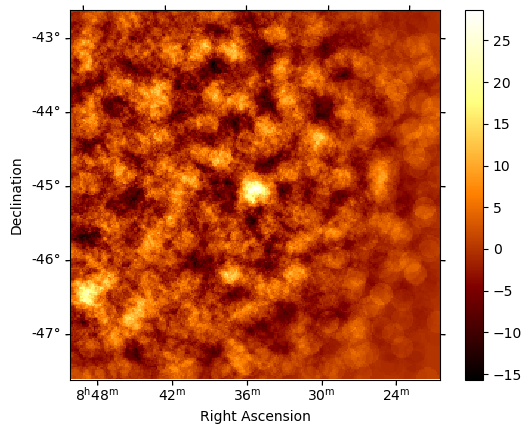

In [17]:
estimator_results.npred_excess.plot(add_cbar=True)

<WCSAxesSubplot: >

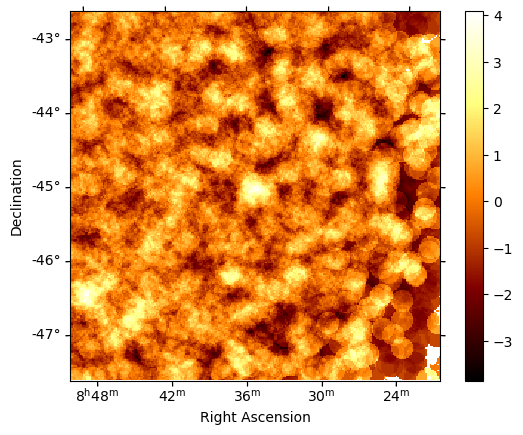

In [51]:
estimator_results.sqrt_ts.plot(add_cbar=True)

Note that here we are lacking statistic because we only use one run of CTA. This explain the "bad look" of our significance map. 

## Phase-resolved spectrum




We can also do a phase-resolved spectrum. In order to do that, we are going to use the `PhaseBackgroundMake` to create a `SpectrumDatasetOnOff`with the ON and OFF taken in the phase space. Note that this maker take the ON and OFF in the same spatial region. 

Here to create the `SpectrumDatasetOnOff`, we are going to redo the whole data reduction. However, note that one can use the `to_spectrum_dataset()`method of `MapDatasetOnOff` (with the `containement_correction` parameter set to `True`) if such a `MapDatasetOnOff`has been created as shown above. 


In [20]:
e_true = MapAxis.from_energy_bounds(0.003, 10, 100, unit="TeV", name="energy_true")
e_reco = MapAxis.from_energy_bounds(0.01, 10, 30, unit="TeV", name="energy")


geom = RegionGeom.create(region=on_region, axes=[e_reco])

spectrum_dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=e_true)

spectrum_dataset_maker = SpectrumDatasetMaker()
phase_bkg_maker = PhaseBackgroundMaker(
    on_phase=on_phase_range, off_phase=off_phase_range, phase_column_name="PHASE"
)
safe_mask_maker = SafeMaskMaker(methods=["edisp-bias"], bias_percent=10)

spectrum_datasets = Datasets()

for obs in obs_list_vela:
    spectrum_dataset = spectrum_dataset_maker.run(spectrum_dataset_empty, obs)
    spectrum_dataset_on_off = phase_bkg_maker.run(spectrum_dataset, obs)
    spectrum_dataset_on_off = safe_mask_maker.run(spectrum_dataset_on_off, obs)
    spectrum_datasets.append(spectrum_dataset_on_off)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
/Users/mregeard/anaconda3/envs/gammapy-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Now let’s a look at the datasets we just created:




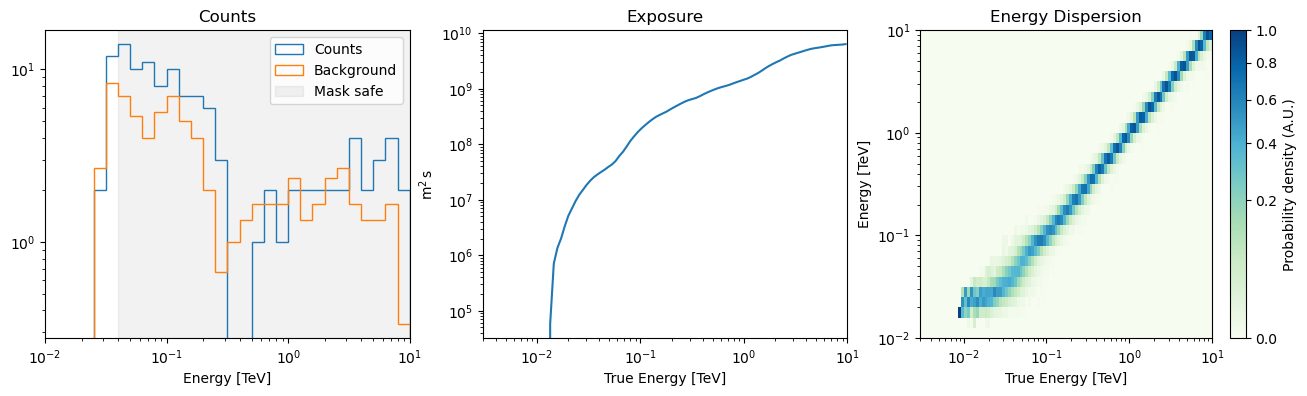

In [21]:
spectrum_datasets[0].peek()

Now we’ll fit a model to the spectrum with the `Fit` class. First we
load a power law model with an initial value for the index and the
amplitude and then wo do a likelihood fit. The fit results are printed
below.




In [22]:
spectral_model = PowerLawSpectralModel(
    index=4, amplitude="1.3e-9 cm-2 s-1 TeV-1", reference="0.02 TeV"
)
model = SkyModel(spectral_model=spectral_model, name="vela psr")
emin_fit, emax_fit = (0.04 * u.TeV, 0.4 * u.TeV)

mask_fit = geom.energy_mask(energy_min=emin_fit, energy_max=emax_fit)

for dataset in spectrum_datasets:
    dataset.models = model
    dataset.mask_fit = mask_fit

joint_fit = Fit()
joint_result = joint_fit.run(datasets=spectrum_datasets)

print(joint_result)

/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:211: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 101
	total stat : 7.07

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:208: RuntimeWarning: overflow encountered in multiply
  C = alpha * (n_on + n_off) - (1 + alpha) * mu_sig
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in square
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: overflow encountered in multiply
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:209: RuntimeWarning: invalid value encountered in multiply
  D = np.sqrt(C**2 + 4 * alpha * (alpha + 1) * n_off * mu_sig)
/Users/mregeard/Workspace/dev/code/gammapy/gammapy/gammapy/stats/fit_statistics.py:211: RuntimeWarning: overflow encountered in multiply
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/mregeard/Workspac

Now you might want to do the stacking here even if in our case there is
only one observation which makes it superfluous. We can compute flux
points by fitting the norm of the global model in energy bands.




In [23]:
energy_edges = np.logspace(np.log10(0.04), np.log10(0.4), 7) * u.TeV

stack_dataset = spectrum_datasets.stack_reduce()

stack_dataset.models = model

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="vela psr", selection_optional="all"
)

flux_points = fpe.run(datasets=[stack_dataset])
flux_points.meta["ts_threshold_ul"] = 1

amplitude_ref = 0.57 * 19.4e-14 * u.Unit("1 / (cm2 s MeV)")
spec_model_true = PowerLawSpectralModel(
    index=4.5, amplitude=amplitude_ref, reference="20 GeV"
)

flux_points_dataset = FluxPointsDataset(data=flux_points, models=model)

Now we can plot.




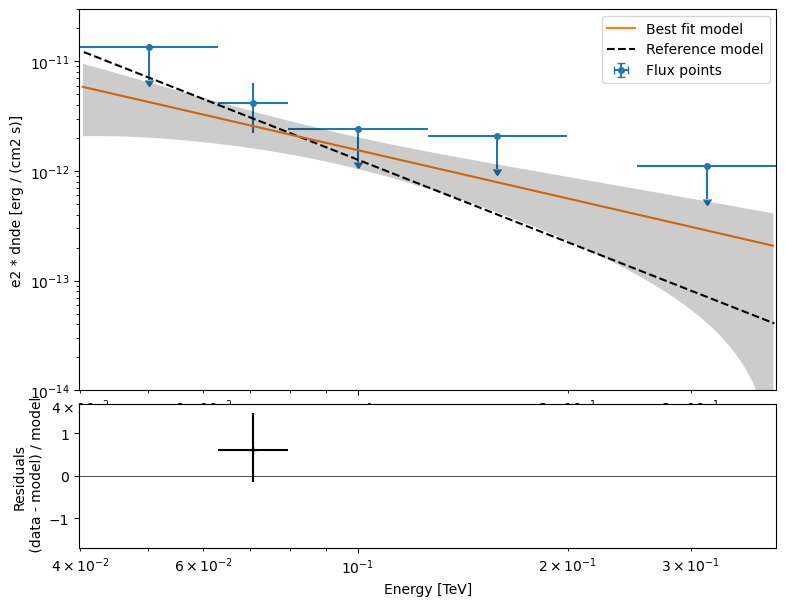

In [24]:
ax_spectrum, ax_residuals = flux_points_dataset.plot_fit()

ax_spectrum.set_ylim([1e-14, 3e-11])
ax_residuals.set_ylim([-1.7, 1.7])

spec_model_true.plot(
    ax=ax_spectrum,
    energy_bounds=(emin_fit, emax_fit),
    label="Reference model",
    c="black",
    linestyle="dashed",
    energy_power=2,
)

ax_spectrum.legend(loc="best")

plt.show()

This tutorial suffers a bit from the lack of statistics: there were 9
Vela observations in the CTA DC1 while there is only one here. When done
on the 9 observations, the spectral analysis is much better agreement
between the input model and the gammapy fit.


